### Import the dataset and packages

The dataset is downloaded from Kaggle: [link](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv)

You can download it with the following link or download the train.csv file through Kaggle.

In [240]:
!wget -O data.csv https://www.dropbox.com/scl/fi/70e8lr0rsfx5crpmoxj8w/train_ensf.csv?rlkey=4s7p9dpm4fl9hnxiqtrmf2l7z&dl=0

In [241]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('punkt')
import string

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

[nltk_data] Downloading package punkt to /home/mik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**NLTK (Natural Language Toolkit):**

NLTK is a leading platform for building Python programs to work with human language data.
It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for tokenization, parsing, stemming, tagging, and semantic reasoning.

**nltk.corpus.stopwords:**

This module contains a collection of stopwords for various languages.
Stopwords are common words (such as "the", "is", "at", "which", etc.) that are often removed from text during natural language processing tasks like text classification, sentiment analysis, etc.

**nltk.stem.SnowballStemmer:**

Snowball stemming is an algorithm for removing suffixes from words to obtain their root form, or stem.
This module provides an implementation of the Snowball stemming algorithm for various languages.

**nltk.download('punkt'):**

This command downloads the Punkt tokenizer models from NLTK.
The Punkt tokenizer is a pre-trained unsupervised machine learning model for tokenizing text into sentences and words.

**string:**

The string module provides a collection of constants representing ASCII characters of lowercase and uppercase letters, digits, and punctuation symbols.
It is commonly used for string manipulation tasks like removing punctuation from text, checking if a character is a letter or digit, etc.

**re (Regular Expression):**

The re module provides support for working with regular expressions in Python.
It allows you to search, match, and manipulate strings based on specified patterns.

In [242]:
# read the dataset
FILE_PATH = './content/data.csv'
df = pd.read_csv(FILE_PATH)
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [243]:
# Check the length of the dataframe
print(len(df))

7613


In [244]:
# look at the head of the dataframe
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [245]:
# Find the unique values in the target column
df.target.unique()

array([1, 0])

In [246]:
# Create a column called 'label' and decode the target value 0/1 to not_disasterous/disasterous
decode_map = {0: 'not_disasterous', 1: "disasterous" }

def decode_sentiment(label):
    return decode_map[int(label)]

df.loc[:, 'label'] = df.target.apply(lambda x: decode_sentiment(x))

In [247]:
# Check if the label column is created (use head())
df.head()

,id,keyword,location,text,target,label
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,disasterous
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,disasterous
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,disasterous
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,disasterous
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,disasterous


In [248]:
# check the null values
print('null values in each column:\n\n', df.isnull().sum())

null values in each column:

 id             0
keyword       61
location    2533
text           0
target         0
label          0
dtype: int64


In [249]:
# fill keyword and location with no_key and no_location
df.keyword.fillna('no_keyword', inplace = True)
df.location.fillna('nolocation', inplace = True)

In [250]:
# check the null values again..
print('null values in each column:\n\n', df.isnull().sum())

null values in each column:

 id          0
keyword     0
location    0
text        0
target      0
label       0
dtype: int64


Text(0.5, 1.0, 'Dataset labels distribuition')

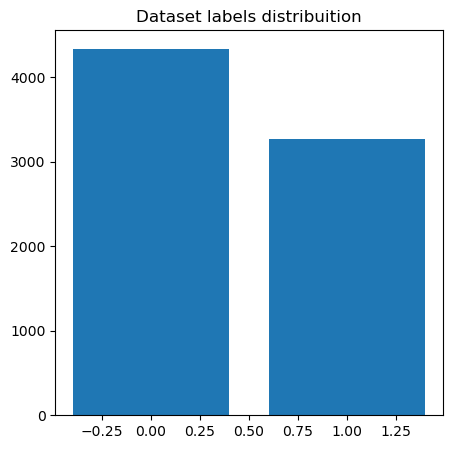

In [251]:
# visualize the number of negative and positive examples using counter and plt.bar (.keys() for the categories available and .values() is for the count of each category)
target_cnt = Counter(df.target)

plt.figure(figsize=(5,5))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Text(0.5, 0, 'number of tweets')

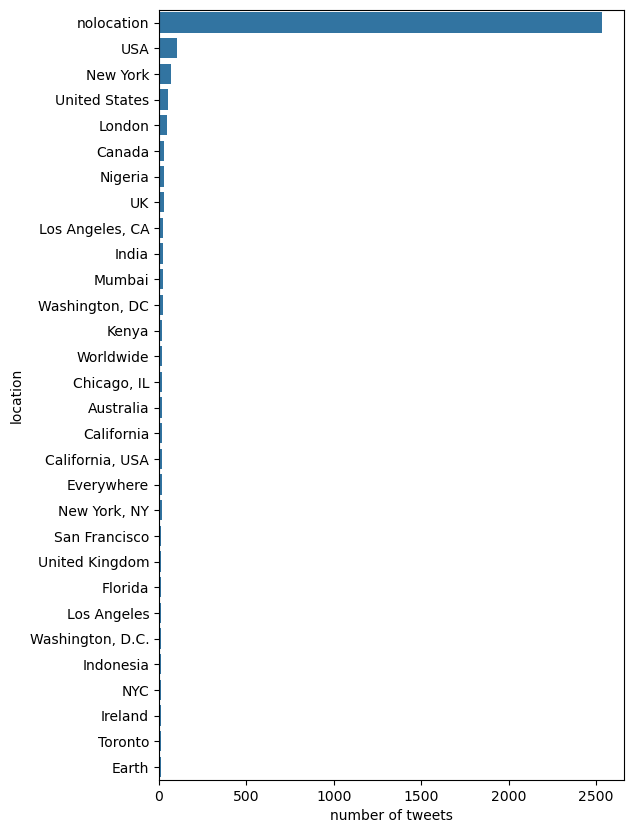

In [252]:
# Use df.groupby to find the top 30 locations in the dataset

top_30 = df.groupby(['location']).count().text.sort_values(ascending = False)[:30]

# plot the top 30 locations using sns.barplot

plt.figure(figsize = (6,10))
sns.barplot(x = top_30, y = top_30.index)
plt.xlabel('number of tweets')

### Text Preprocessing

In [253]:
# Create a function to perfrom preprocessing on the text column
def preprocess(text:str) -> str:

    # lower case the words
    text = text.lower()

    # remove hyperlinks
    text = re.sub(r"\S*https?:\S*", "", text)

    # remove mentions and hashtags
    text = re.sub(r"[@#]\W*\_*", "", text)

    # substitute patterns with their correct representation (ex. &amp --> &)
    rep_character_entity_refrences = {"&gt": ">", "&lt": "<", "&amp": "&"}

    for k,v in rep_character_entity_refrences.items():
        text = re.sub(k, v, text)

    return text

# Create a new column called "cleaned_text" and save the preprocessed text column in
df.loc[:, 'cleaned_text'] = df.loc[:, 'text'].apply(lambda x: preprocess(x))

In [254]:
# View the dataframe to check the cleaned_text column
df

,id,keyword,location,text,target,label,cleaned_text
0,1,no_keyword,nolocation,Our Deeds are the Reason of this #earthquake M...,1,disasterous,our deeds are the reason of this earthquake ma...
1,4,no_keyword,nolocation,Forest fire near La Ronge Sask. Canada,1,disasterous,forest fire near la ronge sask. canada
2,5,no_keyword,nolocation,All residents asked to 'shelter in place' are ...,1,disasterous,all residents asked to 'shelter in place' are ...
3,6,no_keyword,nolocation,"13,000 people receive #wildfires evacuation or...",1,disasterous,"13,000 people receive wildfires evacuation ord..."
4,7,no_keyword,nolocation,Just got sent this photo from Ruby #Alaska as ...,1,disasterous,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...,...
7608,10869,no_keyword,nolocation,Two giant cranes holding a bridge collapse int...,1,disasterous,two giant cranes holding a bridge collapse int...
7609,10870,no_keyword,nolocation,@aria_ahrary @TheTawniest The out of control w...,1,disasterous,aria_ahrary thetawniest the out of control wil...
7610,10871,no_keyword,nolocation,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,disasterous,m1.94 [01:04 utc]?5km s of volcano hawaii.
7611,10872,no_keyword,nolocation,Police investigating after an e-bike collided ...,1,disasterous,police investigating after an e-bike collided ...


In [255]:
# Create a function to remove stopwords

# nltk stopwords: common words (such as "the", "is", "at", "which", etc.)
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')

# spacy stopwords: common words (such as "me", "you", "we", "it", "they", etc.)
import spacy
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = list(nlp.Defaults.stop_words.copy())

# Extra words to remove: (absolutely, actually)
words_to_remove =  ['absolutely', 'actually']

# Put all the stop words to remove in one set
all_stopwords = set(
    nltk_stopwords + spacy_stopwords + words_to_remove
    )

# Write the function here
def remove_st(text:str) -> str:

    # Remove stopwords
    filtered_words = [word for word in text.split() if word not in all_stopwords]

    # Join the filtered words back into a sentence
    filtered_text = ' '.join(filtered_words)

    return filtered_text

# apply the remove st on cleaned_text and save it in a new column called "cleaned_text_no_st"
df.loc[:, 'cleaned_text_no_st'] = df.loc[:, 'cleaned_text'].apply(lambda x: remove_st(x))

[nltk_data] Downloading package stopwords to /home/mik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [256]:
#view df
df

,id,keyword,location,text,target,label,cleaned_text,cleaned_text_no_st
0,1,no_keyword,nolocation,Our Deeds are the Reason of this #earthquake M...,1,disasterous,our deeds are the reason of this earthquake ma...,deeds reason earthquake allah forgive
1,4,no_keyword,nolocation,Forest fire near La Ronge Sask. Canada,1,disasterous,forest fire near la ronge sask. canada,forest fire near la ronge sask. canada
2,5,no_keyword,nolocation,All residents asked to 'shelter in place' are ...,1,disasterous,all residents asked to 'shelter in place' are ...,residents asked 'shelter place' notified offic...
3,6,no_keyword,nolocation,"13,000 people receive #wildfires evacuation or...",1,disasterous,"13,000 people receive wildfires evacuation ord...","13,000 people receive wildfires evacuation ord..."
4,7,no_keyword,nolocation,Just got sent this photo from Ruby #Alaska as ...,1,disasterous,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,nolocation,Two giant cranes holding a bridge collapse int...,1,disasterous,two giant cranes holding a bridge collapse int...,giant cranes holding bridge collapse nearby homes
7609,10870,no_keyword,nolocation,@aria_ahrary @TheTawniest The out of control w...,1,disasterous,aria_ahrary thetawniest the out of control wil...,aria_ahrary thetawniest control wild fires cal...
7610,10871,no_keyword,nolocation,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,disasterous,m1.94 [01:04 utc]?5km s of volcano hawaii.,m1.94 [01:04 utc]?5km volcano hawaii.
7611,10872,no_keyword,nolocation,Police investigating after an e-bike collided ...,1,disasterous,police investigating after an e-bike collided ...,police investigating e-bike collided car littl...


In [257]:
# Create a function to remove punctation and digits
def remove_punctuation_and_digits(text:str) -> str:

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Remove digits
    text = re.sub(r'\d', '', text)

    # removes all single letters surrounded with space except letters "I" and "a"
    text = re.sub(r"(?:^|\s)(?![ia])[a-z] +", ' ', text)

    return text

In [258]:
#Apply the remove punctiation and digits to the "cleaned_text" and "cleaned_text_no_st" columns
df.loc[:, 'cleaned_text'] = df.loc[:, 'cleaned_text'].apply(lambda x: remove_punctuation_and_digits(x))
df.loc[:, 'cleaned_text_no_st'] = df.loc[:, 'cleaned_text_no_st'].apply(lambda x: remove_punctuation_and_digits(x))

In [259]:
#View df
df

,id,keyword,location,text,target,label,cleaned_text,cleaned_text_no_st
0,1,no_keyword,nolocation,Our Deeds are the Reason of this #earthquake M...,1,disasterous,our deeds are the reason of this earthquake ma...,deeds reason earthquake allah forgive
1,4,no_keyword,nolocation,Forest fire near La Ronge Sask. Canada,1,disasterous,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,no_keyword,nolocation,All residents asked to 'shelter in place' are ...,1,disasterous,all residents asked to shelter in place are be...,residents asked shelter place notified officer...
3,6,no_keyword,nolocation,"13,000 people receive #wildfires evacuation or...",1,disasterous,people receive wildfires evacuation orders in...,people receive wildfires evacuation orders ca...
4,7,no_keyword,nolocation,Just got sent this photo from Ruby #Alaska as ...,1,disasterous,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,nolocation,Two giant cranes holding a bridge collapse int...,1,disasterous,two giant cranes holding a bridge collapse int...,giant cranes holding bridge collapse nearby homes
7609,10870,no_keyword,nolocation,@aria_ahrary @TheTawniest The out of control w...,1,disasterous,aria_ahrary thetawniest the out of control wil...,aria_ahrary thetawniest control wild fires cal...
7610,10871,no_keyword,nolocation,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,disasterous,utckm of volcano hawaii,utckm volcano hawaii
7611,10872,no_keyword,nolocation,Police investigating after an e-bike collided ...,1,disasterous,police investigating after an ebike collided w...,police investigating ebike collided car little...


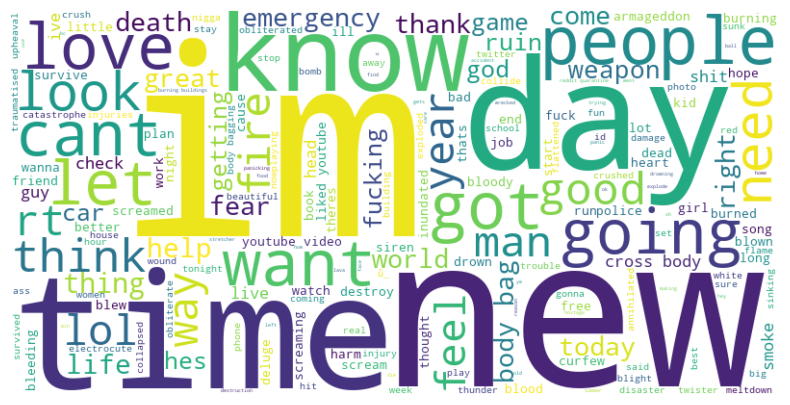

In [260]:
# build a word cloud for target == 0 (Completed for you)

from wordcloud import WordCloud

# Combine all text from the specified column into a single string
text = ' '.join(df[df.target==0]['cleaned_text_no_st'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

Most frequent words:
fire: 178
news: 137
disaster: 118
california: 111
suicide: 110
police: 107
people: 105
killed: 93
like: 92
pm: 89


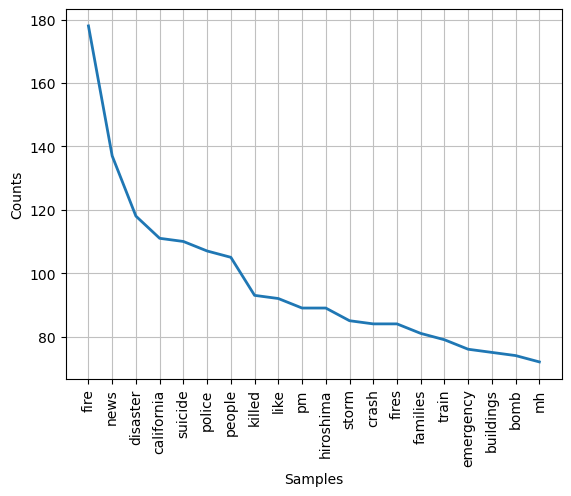

In [261]:
# view the most frequent words for target == 1
# Tokenize the text in the specified column

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

tokens = []
for text in df[df.target==1]['cleaned_text_no_st']:
    tokens.extend(word_tokenize(text))

# Calculate the frequency distribution of tokens
freq_dist = FreqDist(tokens)

# Display the most frequent words and their counts
most_common_words = freq_dist.most_common(10)
print("Most frequent words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Plot a dist.plot of the frequency distribution
freq_dist.plot(20, cumulative = False)
plt.show()

Most frequent words:
fire: 178
news: 137
disaster: 118
california: 111
suicide: 110
police: 107
people: 105
killed: 93
like: 92
pm: 89


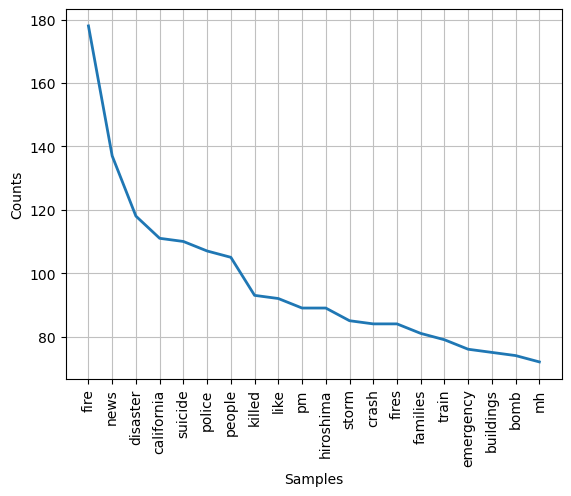

In [262]:
# view the most frequent words for target == 1
# Tokenize the text in the specified column

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

tokens = []
for text in df[df.target==1]['cleaned_text_no_st']:
    tokens.extend(word_tokenize(text))

# Calculate the frequency distribution of tokens
freq_dist = FreqDist(tokens)

# Display the most frequent words and their counts
most_common_words = freq_dist.most_common(10)
print("Most frequent words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Plot a dist.plot of the frequency distribution
freq_dist.plot(20, cumulative = False)
plt.show()


### Prediction with RidgeClassifier, NaiveBayes, LinearSVM
Here we'll use counter vectorizer to specify one column for each word in the tweets and use it as a feature for prediction. If a tweet has a word, the column specific to that word will have the value of 1 (or more based on how many times that word has been repeated in that tweet.)

**Example:**

Assuming these vocab: ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

This sentence will be transformed as follows:
"This document is the second document" --> [0 2 0 1 0 1 1 0 1]

As for the models, we chose these three because they can predict sparse data fast. You can go on and do gridsearch on them and find the best parameters for each.

In [263]:
from sklearn.feature_extraction.text import CountVectorizer

# create a CountVectorizer function (CountVectorizer is a method used for converting a collection of text documents into a matrix of token counts)
counter_vectorizer = CountVectorizer()

# fit and transform the df
counter_vectorizer.fit(df.cleaned_text_no_st)
transformed_rows = counter_vectorizer.transform(df.cleaned_text_no_st).todense()

In [264]:
transformed_rows.shape

(7613, 17084)

In [265]:
# use the three algorithms and build cross validation to assess their performance
# make sure to create one pipeline with a feature selection algorithm inside it as well
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# Assuming you have your 'y' --> "target" col and 'X' --> 'transformed_rows'
# Example data
np.random.seed(42)
X = np.asarray(transformed_rows)
y = df.target.values.reshape(-1, 1)

# Create a pipeline with feature selection and classifiers for Ridge Classifier
ridge_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', RidgeClassifier())
])

# Create a pipeline with feature selection and classifiers for Naive Bayes
naive_bayes_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', MultinomialNB())
])

# Create a pipeline with feature selection and classifiers for SVM
linear_svm_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', SVC(kernel='linear'))
])

# Define the classifiers
classifiers = {
    'Ridge Classifier': ridge_pipeline,
    'Naive Bayes': naive_bayes_pipeline,
    'Linear SVM': linear_svm_pipeline
}

# Perform cross-validation and compare results
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run all models and compare
for name, clf in classifiers.items():
    y_pred = cross_val_predict(clf, X, y, cv = cv)

    # Print confusion matrix and metrics
    print(f'\nResults for {name}:')
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(y, y_pred))

    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    f1 = metrics.f1_score(y, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('-------------------------------')


Results for Ridge Classifier:
Confusion Matrix:
[[3989  353]
 [1677 1594]]
Accuracy: 0.73
Precision: 0.82
Recall: 0.49
F1 Score: 0.61
-------------------------------

Results for Naive Bayes:
Confusion Matrix:
[[4132  210]
 [1976 1295]]
Accuracy: 0.71
Precision: 0.86
Recall: 0.40
F1 Score: 0.54
-------------------------------

Results for Linear SVM:
Confusion Matrix:
[[3951  391]
 [1643 1628]]
Accuracy: 0.73
Precision: 0.81
Recall: 0.50
F1 Score: 0.62
-------------------------------
